In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.callbacks import EarlyStopping, CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
path='/content/drive/MyDrive/캡스톤디자인I/EEG_DATA_Shuffle_500.csv'
dataDF = pd.read_csv(path)
dataDF = dataDF[dataDF.iloc[:, -1] != 2]
dataDF = dataDF.drop('Unnamed: 0', axis=1)
dataDF

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,7.7005,16.5688,14.6191,-2.7372,9.7376,9.6343,12.7423,15.5180,23.1480,3.2137,...,20.2932,19.9336,26.9401,0.4877,15.9825,15.2125,28.8786,13.1696,29.3290,1.0
3,-76.7901,10.4661,60.9218,39.1930,33.3773,65.0877,49.0782,5.1342,43.5867,0.9796,...,-38.8314,-50.8898,-42.2924,-22.9204,-48.7766,-44.7011,-38.4557,-40.1042,-36.8672,1.0
4,9.5458,8.5632,2.2690,-7.9035,7.0756,7.6126,9.5961,8.0069,60.6086,-3.4619,...,-17.7538,-3.9169,-11.5917,-7.9538,-12.3448,-18.7311,-4.8867,-10.0855,5.3741,1.0
5,54.1066,-29.2396,-52.1869,-46.1536,-39.8975,-55.1390,-20.3230,20.2025,-16.8425,16.3951,...,-58.7427,-43.0384,-24.9481,-13.5026,-74.4552,-17.3629,-48.7126,-28.2805,-16.2469,0.0
6,-21.9437,-34.9235,-27.5263,-20.9710,-0.9563,3.7334,-7.1844,-14.7087,3.9823,-16.8421,...,0.6112,-1.8943,-4.1084,6.3730,-5.9389,8.8530,-0.3462,-14.9738,-15.7967,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,31.8298,28.2079,16.0677,16.1556,17.7885,10.1546,5.3282,8.8298,-6.3858,-37.7427,...,-13.2528,-33.0454,-21.1263,-9.9571,-86.3534,-24.2241,-32.5561,-5.7018,3.6393,1.0
3371,-7.0424,-19.2560,1.3570,-6.2609,-12.3790,-10.1178,-10.6833,2.2586,3.8605,-12.5384,...,1.5050,-16.4925,-26.9612,-13.1342,-21.2572,-1.3507,-27.7396,-6.2248,-9.7443,1.0
3372,-34.5889,-16.0601,3.5147,56.5993,-13.7713,-1.4305,18.7316,-2.2079,3.7468,0.6465,...,2.6975,20.9829,10.2222,4.9892,-9.2410,3.5549,13.9819,-3.4836,-1.3360,0.0
3373,-7.7020,-32.1352,-19.0261,18.9835,-12.2132,-22.5264,-5.8123,-6.4590,-868.1081,0.2058,...,-1.5312,-23.7726,-16.1596,3.1612,0.3230,6.0892,-14.2523,3.1717,-37.0443,4.0


In [28]:
dataDF.replace({3: 2}, inplace=True)
dataDF.replace({4: 3}, inplace=True)

In [29]:
mapping_dict = {idx: i for i, idx in enumerate(dataDF.index[:2701])}

dataDF.index = dataDF.index.map(mapping_dict)

In [30]:
dataDF

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,7.7005,16.5688,14.6191,-2.7372,9.7376,9.6343,12.7423,15.5180,23.1480,3.2137,...,20.2932,19.9336,26.9401,0.4877,15.9825,15.2125,28.8786,13.1696,29.3290,1.0
1,-76.7901,10.4661,60.9218,39.1930,33.3773,65.0877,49.0782,5.1342,43.5867,0.9796,...,-38.8314,-50.8898,-42.2924,-22.9204,-48.7766,-44.7011,-38.4557,-40.1042,-36.8672,1.0
2,9.5458,8.5632,2.2690,-7.9035,7.0756,7.6126,9.5961,8.0069,60.6086,-3.4619,...,-17.7538,-3.9169,-11.5917,-7.9538,-12.3448,-18.7311,-4.8867,-10.0855,5.3741,1.0
3,54.1066,-29.2396,-52.1869,-46.1536,-39.8975,-55.1390,-20.3230,20.2025,-16.8425,16.3951,...,-58.7427,-43.0384,-24.9481,-13.5026,-74.4552,-17.3629,-48.7126,-28.2805,-16.2469,0.0
4,-21.9437,-34.9235,-27.5263,-20.9710,-0.9563,3.7334,-7.1844,-14.7087,3.9823,-16.8421,...,0.6112,-1.8943,-4.1084,6.3730,-5.9389,8.8530,-0.3462,-14.9738,-15.7967,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,31.8298,28.2079,16.0677,16.1556,17.7885,10.1546,5.3282,8.8298,-6.3858,-37.7427,...,-13.2528,-33.0454,-21.1263,-9.9571,-86.3534,-24.2241,-32.5561,-5.7018,3.6393,1.0
2696,-7.0424,-19.2560,1.3570,-6.2609,-12.3790,-10.1178,-10.6833,2.2586,3.8605,-12.5384,...,1.5050,-16.4925,-26.9612,-13.1342,-21.2572,-1.3507,-27.7396,-6.2248,-9.7443,1.0
2697,-34.5889,-16.0601,3.5147,56.5993,-13.7713,-1.4305,18.7316,-2.2079,3.7468,0.6465,...,2.6975,20.9829,10.2222,4.9892,-9.2410,3.5549,13.9819,-3.4836,-1.3360,0.0
2698,-7.7020,-32.1352,-19.0261,18.9835,-12.2132,-22.5264,-5.8123,-6.4590,-868.1081,0.2058,...,-1.5312,-23.7726,-16.1596,3.1612,0.3230,6.0892,-14.2523,3.1717,-37.0443,3.0


In [31]:
ct = 500

x_data = []
y_data = []

print(len(dataDF))

for i in range(len(dataDF)):
    print(i)
    x_data.append([])
    x = 0
    y = 20
    one_row_data = dataDF.iloc[i]
    y_data.append(one_row_data[y - 1])
    for j in range(ct):
        x_data[i].append([one_row_data[x:y - 1]])
        x += 20
        y += 20

x_data = np.array(x_data).reshape(len(x_data), ct, 19)
y_data = np.array(pd.get_dummies(y_data))

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=2024)

2700
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [32]:
print("Training set shapes:")
print(x_train.shape)
print(y_train.shape)
print("-------------------")
print("Validation set shapes:")
print(x_val.shape)
print(y_val.shape)
print("-------------------")
print("Test set shapes:")
print(x_test.shape)
print(y_test.shape)

Training set shapes:
(2160, 500, 19)
(2160, 4)
-------------------
Validation set shapes:
(270, 500, 19)
(270, 4)
-------------------
Test set shapes:
(270, 500, 19)
(270, 4)


In [33]:
# 트랜스포머 Block 1개
def transformer_block(input):
  x = keras.layers.MultiHeadAttention(num_heads=16, key_dim=1, dropout=0.1)(input, input, return_attention_scores=False)
  x = x + input
  x = keras.layers.LayerNormalization()(x)
  x2 = keras.layers.Dense(19,activation='relu')(x)
  x2 = x + x2
  x3 = keras.layers.LayerNormalization()(x2)
  return x3

In [34]:
# 위의 transformer_block()을 사용해서 모델을 만드는 함수
def build_model(num_block):
  inputs = keras.Input((ct,19))
  x = inputs
  for _ in range(num_block):
    x = transformer_block(x)
  x = keras.layers.GlobalAveragePooling1D()(x)
  output = keras.layers.Dense(4,activation='softmax')(x)
  return keras.Model(inputs,output)

In [35]:
num_block = 4
myMdl = build_model(num_block)
myMdl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500, 19)]            0         []                            
                                                                                                  
 multi_head_attention_6 (Mu  (None, 500, 19)              1283      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 tf.__operators__.add_12 (T  (None, 500, 19)              0         ['multi_head_attention_6[0][0]
 FOpLambda)                                                         ',                            
                                                                     'input_2[0][0]']       

In [36]:
#에포크마다 모델을 저장하고 loss를 기록한 csv 저장을 위한 코드
root = '/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/'
folder_name = '20240415_6modelsave'
os.mkdir(root+folder_name)
csv_logger = CSVLogger(root+folder_name+'/training.csv', separator=",", append=True)
mcp_save_best = tf.keras.callbacks.ModelCheckpoint(
    root+folder_name+'/{epoch:02d}-{val_loss:.5f}_best', save_best_only=True,
    monitor='val_loss', verbose=1, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    root+folder_name+'/{epoch:02d}-{val_loss:.5f}', save_best_only=False,
    monitor='val_loss', verbose=1, mode='min')

In [37]:
adam = Adam(learning_rate=0.001)
#옵티마이저를 Adam 알고리즘을 사용합니다. 학습률을 0.001로 설정(학습률은 가중치를 얼마나 업데이트할지 이를 조정하여 모델의 성능을 조정)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc_loss = ModelCheckpoint('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5', monitor='val_loss', verbose=1, save_best_only=True)
#훈련중 손실값을 모니터링하여 조기 종료하는 콜백 함수
mc = ModelCheckpoint('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#모델의 검증 정확도를 확인하여 가장 좋은 시점의 모델을 저장함.
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
#학습률을 조정하는 콜백 함수
myMdl.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
#모델의 옵티마이저를 설정, 손실함수, 정확도를 출력
trans_h = myMdl.fit(x_train, y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=200,
                   callbacks=[es, mc, mc_loss,mcp_save_best,mcp_save, lr_schedule, csv_logger])

Epoch 1/200
68/68 [==============================] - ETA: 0s - loss: 1.2449 - accuracy: 0.4819
Epoch 1: val_accuracy improved from -inf to 0.63704, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 1.03932, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 1: val_loss improved from inf to 1.03932, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/01-1.03932_best

Epoch 1: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/01-1.03932
68/68 [==============================] - 51s 591ms/step - loss: 1.2449 - accuracy: 0.4819 - val_loss: 1.0393 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.6856
Epoch 2: val_accuracy improved from 0.63704 to 0.73704, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.03932 to 0.75433, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 2: val_loss improved from 1.03932 to 0.75433, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/02-0.75433_best

Epoch 2: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/02-0.75433
68/68 [==============================] - 40s 585ms/step - loss: 0.8903 - accuracy: 0.6856 - val_loss: 0.7543 - val_accuracy: 0.7370 - lr: 9.0484e-04
Epoch 3/200
68/68 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7569
Epoch 3: val_accuracy improved from 0.73704 to 0.77407, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.75433 to 0.64795, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 3: val_loss improved from 0.75433 to 0.64795, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/03-0.64795_best

Epoch 3: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/03-0.64795
68/68 [==============================] - 39s 583ms/step - loss: 0.6586 - accuracy: 0.7569 - val_loss: 0.6480 - val_accuracy: 0.7741 - lr: 8.1873e-04
Epoch 4/200
68/68 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.8208
Epoch 4: val_accuracy improved from 0.77407 to 0.80000, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_loss improved from 0.64795 to 0.58957, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 4: val_loss improved from 0.64795 to 0.58957, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/04-0.58957_best

Epoch 4: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/04-0.58957
68/68 [==============================] - 40s 585ms/step - loss: 0.5222 - accuracy: 0.8208 - val_loss: 0.5896 - val_accuracy: 0.8000 - lr: 7.4082e-04
Epoch 5/200
68/68 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8583
Epoch 5: val_accuracy improved from 0.80000 to 0.81852, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 0.58957 to 0.50617, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 5: val_loss improved from 0.58957 to 0.50617, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/05-0.50617_best

Epoch 5: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/05-0.50617
68/68 [==============================] - 40s 585ms/step - loss: 0.4143 - accuracy: 0.8583 - val_loss: 0.5062 - val_accuracy: 0.8185 - lr: 6.7032e-04
Epoch 6/200
68/68 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8662
Epoch 6: val_accuracy improved from 0.81852 to 0.84444, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: val_loss improved from 0.50617 to 0.45954, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 6: val_loss improved from 0.50617 to 0.45954, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/06-0.45954_best

Epoch 6: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/06-0.45954
68/68 [==============================] - 40s 585ms/step - loss: 0.3636 - accuracy: 0.8662 - val_loss: 0.4595 - val_accuracy: 0.8444 - lr: 6.0653e-04
Epoch 7/200
68/68 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.8972
Epoch 7: val_accuracy improved from 0.84444 to 0.84815, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 7: val_loss improved from 0.45954 to 0.45237, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 7: val_loss improved from 0.45954 to 0.45237, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/07-0.45237_best

Epoch 7: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/07-0.45237
68/68 [==============================] - 39s 583ms/step - loss: 0.3046 - accuracy: 0.8972 - val_loss: 0.4524 - val_accuracy: 0.8481 - lr: 5.4881e-04
Epoch 8/200
68/68 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9106
Epoch 8: val_accuracy did not improve from 0.84815

Epoch 8: val_loss did not improve from 0.45237

Epoch 8: val_loss did not improve from 0.45237

Epoch 8: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/08-0.45653
68/68 [==============================] - 33s 491ms/step - loss: 0.261

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 9: val_loss improved from 0.45237 to 0.41057, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 9: val_loss improved from 0.45237 to 0.41057, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/09-0.41057_best

Epoch 9: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/09-0.41057
68/68 [==============================] - 40s 585ms/step - loss: 0.2362 - accuracy: 0.9255 - val_loss: 0.4106 - val_accuracy: 0.8704 - lr: 4.4933e-04
Epoch 10/200
68/68 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9412
Epoch 10: val_accuracy did not improve from 0.87037

Epoch 10: val_loss improved from 0.41057 to 0.39844, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 10: val_loss improved from 0.41057 to 0.39844, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/10-0.39844_best

Epoch 10: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/10-0.39844
68/68 [==============================] - 39s 574ms/step - loss: 0.2079 - accuracy: 0.9412 - val_loss: 0.3984 - val_accuracy: 0.8667 - lr: 4.0657e-04
Epoch 11/200
68/68 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9463
Epoch 11: val_accuracy did not improve from 0.87037

Epoch 11: val_loss did not improve from 0.39844

Epoch 11: val_loss did not improve from 0.39844

Epoch 11: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/11-0.39916
68/68 [==============================] - 32s 471ms/step - loss: 0.1842 - accuracy: 0.9463 - val_loss: 0.3992 - val_accuracy: 0.8704 - lr: 3.6788e-04
Epoch 12/200
68/68 [==============================] - ETA: 0s - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 13: val_loss improved from 0.39844 to 0.38211, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 13: val_loss improved from 0.39844 to 0.38211, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/13-0.38211_best

Epoch 13: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/13-0.38211
68/68 [==============================] - 40s 584ms/step - loss: 0.1570 - accuracy: 0.9546 - val_loss: 0.3821 - val_accuracy: 0.8815 - lr: 3.0119e-04
Epoch 14/200
68/68 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9625
Epoch 14: val_accuracy did not improve from 0.88148

Epoch 14: val_loss did not improve from 0.38211

Epoch 14: val_loss did not improve from 0.38211

Epoch 14: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/14-0.38529
68/68 [==============================] - 32s 472ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 15: val_loss improved from 0.38211 to 0.35798, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5

Epoch 15: val_loss improved from 0.38211 to 0.35798, saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/15-0.35798_best

Epoch 15: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/15-0.35798
68/68 [==============================] - 39s 582ms/step - loss: 0.1278 - accuracy: 0.9597 - val_loss: 0.3580 - val_accuracy: 0.8926 - lr: 2.4660e-04
Epoch 16/200
68/68 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9685
Epoch 16: val_accuracy did not improve from 0.89259

Epoch 16: val_loss did not improve from 0.35798

Epoch 16: val_loss did not improve from 0.35798

Epoch 16: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/16-0.35978
68/68 [==============================] - 33s 481ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 22: val_loss did not improve from 0.35798

Epoch 22: val_loss did not improve from 0.35798

Epoch 22: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/22-0.36082
68/68 [==============================] - 34s 495ms/step - loss: 0.0814 - accuracy: 0.9824 - val_loss: 0.3608 - val_accuracy: 0.8963 - lr: 1.2246e-04
Epoch 23/200
68/68 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9829
Epoch 23: val_accuracy did not improve from 0.89630

Epoch 23: val_loss did not improve from 0.35798

Epoch 23: val_loss did not improve from 0.35798

Epoch 23: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/23-0.36676
68/68 [==============================] - 32s 473ms/step - loss: 0.0795 - accuracy: 0.9829 - val_loss: 0.3668 - val_accuracy: 0.8926 - lr: 1.1080e-04
Epoch 24/200
68/68 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9856
Epoch 24: val_accuracy improved fr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 24: val_loss did not improve from 0.35798

Epoch 24: val_loss did not improve from 0.35798

Epoch 24: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/24-0.36337
68/68 [==============================] - 33s 492ms/step - loss: 0.0754 - accuracy: 0.9856 - val_loss: 0.3634 - val_accuracy: 0.9037 - lr: 1.0026e-04
Epoch 25/200
68/68 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9847Restoring model weights from the end of the best epoch: 15.

Epoch 25: val_accuracy did not improve from 0.90370

Epoch 25: val_loss did not improve from 0.35798

Epoch 25: val_loss did not improve from 0.35798

Epoch 25: saving model to /content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/25-0.36486
68/68 [==============================] - 32s 477ms/step - loss: 0.0735 - accuracy: 0.9847 - val_loss: 0.3649 - val_accuracy: 0.8963 - lr: 9.0718e-05
Epoch 25: early stopping


In [38]:
transformer_best = load_model('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_acc_v8.h5')
transformer_accuracy = transformer_best.evaluate(x_test, y_test, verbose=1)[1]   #테스터 데이터를 사용해 모델 정확도 평가
print("Test Acc. Transformer: {:.3f}%".format(transformer_accuracy * 100))

transformer_best_loss = load_model('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/best_transformer_loss_v8.h5')
transformer_loss = transformer_best_loss.evaluate(x_test, y_test, verbose=1)[0]   #테스터 데이터를 사용해 모델의 손실 평가
print("Test val_Loss. transformer:{:.3f}".format(transformer_loss))

y_pred = np.array(list(map(lambda x: np.argmax(x), transformer_best.predict(x_test))))   #테스트 데이터에 대한 예측 수행 및 confusion matrix 출력하여 성능 평가
y_test = y_test.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits=4)) #digits=4로 소수점 지정

9/9 [==============================] - 2s 109ms/step - loss: 0.2695 - accuracy: 0.9111
Test Acc. Transformer: 91.111%
9/9 [==============================] - 2s 107ms/step - loss: 0.2885 - accuracy: 0.8963
Test val_Loss. transformer:0.289
9/9 [==============================] - 2s 104ms/step
              precision    recall  f1-score   support

           0     0.9365    0.8939    0.9147        66
           1     0.9296    0.9429    0.9362        70
           2     0.9275    0.9143    0.9209        70
           3     0.8507    0.8906    0.8702        64

    accuracy                         0.9111       270
   macro avg     0.9111    0.9104    0.9105       270
weighted avg     0.9121    0.9111    0.9113       270



In [39]:
myMdl = tf.keras.models.load_model('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/15-0.35798_best')

In [40]:
history = pd.read_csv('/content/drive/MyDrive/캡스톤디자인I/Real_Save_Model/20240415_6modelsave/training.csv')

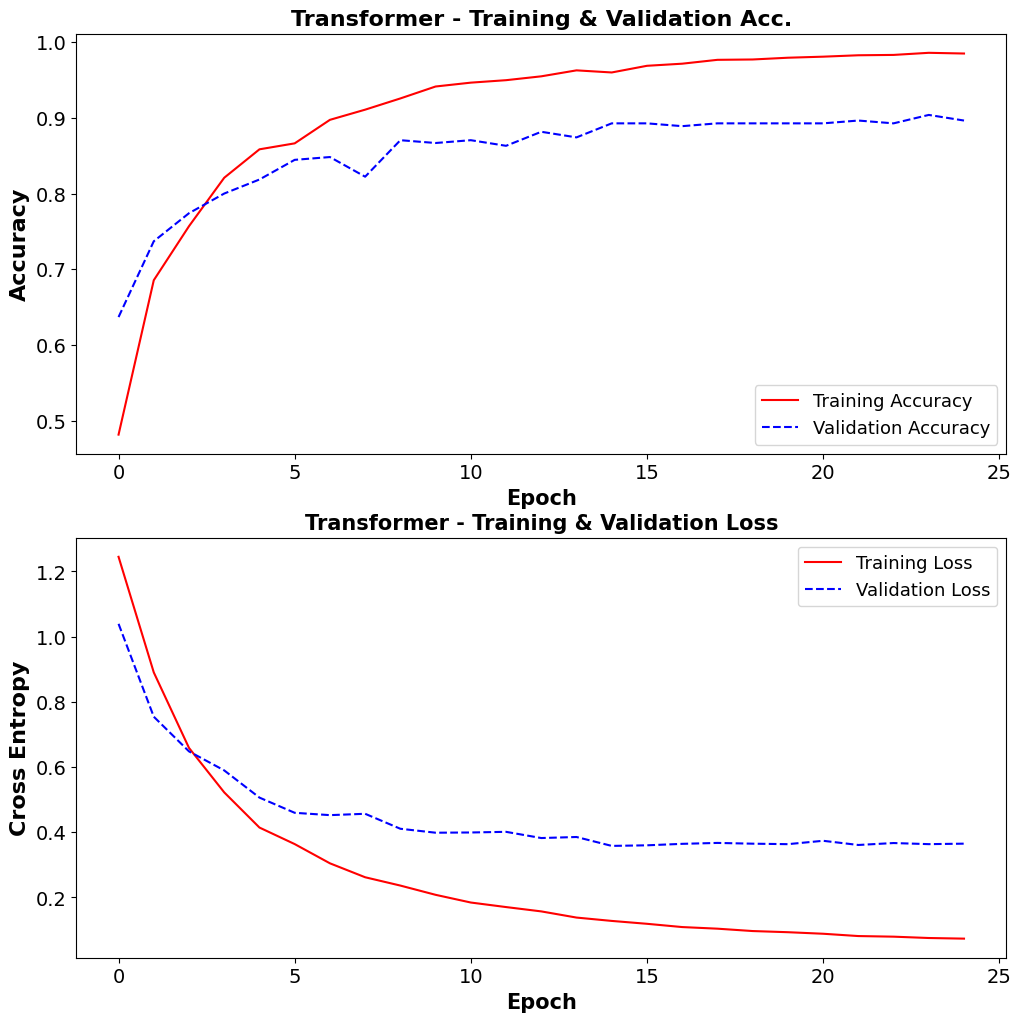

In [41]:
acc = trans_h.history['accuracy']
val_acc = trans_h.history['val_accuracy']
loss = trans_h.history['loss']
val_loss = trans_h.history['val_loss']
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b', linestyle='--') # Modify linestyle for validation accuracy
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Transformer - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b', linestyle='--') # Modify linestyle for validation loss
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Transformer - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

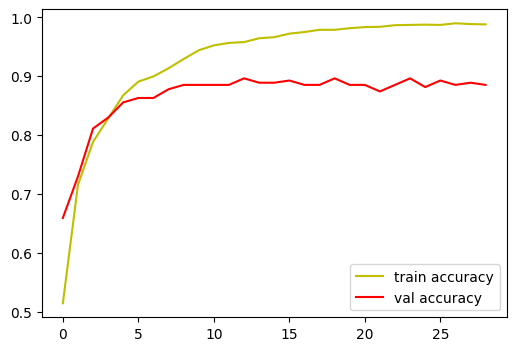

In [22]:
# accuracy curve
plt.figure(figsize=(6, 4))
plt.plot(trans_h.history['accuracy'], 'y', label='train accuracy')
plt.plot(trans_h.history['val_accuracy'], 'r', label='val accuracy')
plt.legend()
plt.show()

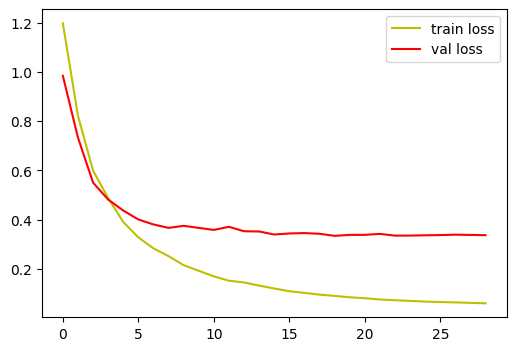

In [23]:
#loss curve
plt.figure(figsize=(6,4))
plt.plot(trans_h.history['loss'][:], 'y', label='train loss')
plt.plot(trans_h.history['val_loss'][:], 'r', label='val loss')
plt.legend()
plt.show()